In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalMaxPooling2D, BatchNormalization, Conv2D, MaxPooling2D, ReLU, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import albumentations as A
import cv2
from glob import glob
from tqdm import tqdm
import numpy as np

def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)


def augment_data(read_path, save_path, category = None, augment=True):
    """ Performing data augmentation. """
    #H = 80
    #W = 80

    for img in os.listdir(read_path):
        """ Extracting the dir name and image name """

        image_path = os.path.join(read_path,img)
        name = img.split(".jpg")[0]
        #print(image_path)


        """ Read the image """
        x = cv2.imread(image_path, cv2.IMREAD_COLOR)

        augmentation_pipeline = A.Compose([

            # Geometric Transformations
            A.HorizontalFlip(p=0.5),  # 50% chance of flipping the image left-right
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),  # Slight shift, scale, rotate

            # Elastic Deformation (Slight)
            #A.ElasticTransform(alpha=1, sigma=50, p=0.5),  # Mild elastic deformation

            # Brightness and Contrast Adjustments
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Adjust brightness and contrast

            # Adding Noise
            A.GaussianBlur(blur_limit=(3, 5), p=0.5),  # Slight Gaussian blur
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.5)  # Add Gaussian noise

            # Cutout/CoarseDropout
            #A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=1, min_height=8, min_width=8, p=0.3),  # Drop random parts

            # Distortions
            #A.GridDistortion(p=0.3),  # Slight grid distortion
            #A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.3),  # Slight optical distortion

            # Padding and Cropping
            #A.PadIfNeeded(min_height=224, min_width=224, p=1.0),
            #A.RandomCrop(height=224, width=224, p=1.0)  # Randomly crop the image to 224x224
            ])

        X = [x]


        if (augment == True) and category == 'ship':

            for _ in range(8):
                augmented = augmentation_pipeline(image=x)
                X.append(augmented["image"])

        elif (augment == True) and category == 'Noship':

            for _ in range(2):
                augmented = augmentation_pipeline(image=x)
                X.append(augmented["image"])


        idx = 0
        for i in X:
            #i = cv2.resize(i, (W, H))

            if len(X) == 1:  # each loop it will take one image
                tmp_image_name = f"{name}.jpg"
            else:
                tmp_image_name = f"{name}_{idx}.jpg"

            image_path = os.path.join(save_path, tmp_image_name)

            cv2.imwrite(image_path, i)

            idx = idx + 1
        #break

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
data_path = "/content/drive/MyDrive/ShipNet/shipsnet"

files = os.listdir(data_path)

print(len(files))

4000


In [ ]:
create_dir('new_data/train/ship')
create_dir('new_data/train/nonship')
create_dir('new_data/val/ship')
create_dir('new_data/val/nonship')
create_dir('new_data/test/ship')
create_dir('new_data/test/nonship')

In [ ]:
ships = []
nonships = []

for _ in files:
  category = float(_.split("__")[0])
  if category == 0 :
    nonships.append(_)
  else:
    ships.append(_)

In [ ]:
print(len(ships))
print(len(nonships))

1000
3000


In [ ]:
import random
np.random.seed(42)
test_size = 0.2

test_of_ships = random.sample(range(0, len(ships)), int(test_size*len(ships)))
test_of_nonships = random.sample(range(0, len(nonships)), int(test_size*len(nonships)))

available_numbers_for_ships = [num for num in range(0, len(ships)) if num not in test_of_ships]
available_numbers_for_nonships = [num for num in range(0, len(nonships)) if num not in test_of_nonships]

valid_of_ships = random.sample(available_numbers_for_ships, int(test_size*len(available_numbers_for_ships)))
valid_of_nonships = random.sample(available_numbers_for_nonships, int(test_size*len(available_numbers_for_nonships)))

train_of_ships = [num for num in available_numbers_for_ships if num not in valid_of_ships]
train_of_nonships = [num for num in available_numbers_for_nonships if num not in valid_of_nonships]

In [ ]:
print(len(test_of_nonships))
print(len(valid_of_nonships))
print(len(train_of_nonships))

print(len(test_of_ships))
print(len(valid_of_ships))
print(len(train_of_ships))

600
480
1920
200
160
640


In [ ]:
def move_images(idx_list,read_path,write_path,data):
    for idx in idx_list:
        image_path = os.path.join(read_path,data[idx])
        name = data[idx].split(".png")[0]
        x = cv2.imread(image_path, cv2.IMREAD_COLOR)

        tmp_image_name = f"{name}.jpg"
        image_write_path = os.path.join(write_path, tmp_image_name)
        cv2.imwrite(image_write_path, x)

In [ ]:
move_images(test_of_nonships,data_path,'new_data/test/nonship',nonships)
move_images(test_of_ships,data_path,'new_data/test/ship',ships)

In [ ]:
move_images(valid_of_ships,data_path,'new_data/val/ship',ships)
move_images(valid_of_nonships,data_path,'new_data/val/nonship',nonships)

In [ ]:
move_images(train_of_nonships,data_path,'new_data/train/nonship',nonships)
move_images(train_of_ships,data_path,'new_data/train/ship',ships)

In [ ]:
print(len(os.listdir('new_data/test/nonship')),
len(os.listdir('new_data/test/ship')),
len(os.listdir('new_data/val/nonship')),
len(os.listdir('new_data/val/ship')),
len(os.listdir('new_data/train/nonship')),
len(os.listdir('new_data/train/ship')))

600 200 480 160 1920 640


In [ ]:
create_dir('new_data/aug_train/ship')
create_dir('new_data/aug_train/nonship')

In [ ]:
augment_data('new_data/train/ship','new_data/aug_train/ship',category = 'ship',augment=True)
augment_data('new_data/train/nonship','new_data/aug_train/nonship',category = 'Noship',augment=True)

In [ ]:
print(len(os.listdir('new_data/aug_train/nonship')),
len(os.listdir('new_data/aug_train/ship')))

5760 5760


In [ ]:
train_path = r'new_data/aug_train/'
test_path = r'new_data/test/'
val_path = r'new_data/val'


train_datagen = ImageDataGenerator(rescale = 1/255.0)

val_datagen = ImageDataGenerator(rescale = 1/255.0)

test_datagen = ImageDataGenerator(rescale = 1/255.0)



train_batches = train_datagen.flow_from_directory(directory = train_path,
                target_size = (80,80), batch_size = 32, shuffle=True)

valid_batches = val_datagen.flow_from_directory(directory = val_path,
                target_size = (80,80), batch_size = 32, shuffle=False)

test_batches = test_datagen.flow_from_directory(directory = test_path,
                target_size = (80,80), batch_size = 32, shuffle=False)

Found 11520 images belonging to 2 classes.
Found 640 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [ ]:
'''
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, ReLU, Add, Input, Flatten, Dense
from tensorflow.keras.models import Model

# Define an Inception block
def inception_block(x, filters):
    f1, f3, f5, fpool = filters

    # 1x1 Convolution
    conv1 = Conv2D(f1, (1, 1), padding='same', activation='relu')(x)

    # 3x3 Convolution
    conv3 = Conv2D(f3, (3, 3), padding='same', activation='relu')(x)

    # 5x5 Convolution
    conv5 = Conv2D(f5, (5, 5), padding='same', activation='relu')(x)

    # Max Pooling followed by 1x1 Convolution
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool = Conv2D(fpool, (1, 1), padding='same', activation='relu')(pool)

    # Concatenate all branches
    output = tf.keras.layers.concatenate([conv1, conv3, conv5, pool])
    return output

# Define a Residual block
def residual_block(x, filters):
    #shortcut = Conv2D(filters, (1, 1), padding='same')(x)  # Adjust filters to match
    shortcut = x

    # 3x3 Convolution
    conv1 = Conv2D(filters, (3, 3), activation='relu')(x)
    conv1 = BatchNormalization()(conv1)

    # 3x3 Convolution
    conv2 = Conv2D(filters, (3, 3), activation='relu')(conv1)
    conv2 = BatchNormalization()(conv2)

    # Add shortcut to the output
    output = Add()([shortcut, conv2])
    return ReLU()(output)

# Build the model
def build_model(input_shape):
    inputs = Input(shape=input_shape)


    # Block 1
    x = Conv2D(8, (3, 3), activation='relu')(inputs)
    x1 = inception_block(x, [8, 8, 8, 8])
    x2 = Conv2D(8, (3, 3), activation='relu', padding='same')(x1)
    x3 = Add()([x, x2])
    pool1 = MaxPooling2D((3, 3))(x3)

    # Block 2
    x4 = Conv2D(16, (3, 3), activation='relu')(pool1)
    x5 = inception_block(x4, [16, 16, 16, 16])
    x6 = Conv2D(16, (3, 3), activation='relu', padding='same')(x5)
    x7 = Add()([x4, x6])
    pool2 = MaxPooling2D((3, 3))(x7)

    # Block 3
    x8 = Conv2D(32, (3, 3), activation='relu')(pool2)
    x9 = inception_block(x8, [32, 32, 32, 32])
    x10 = Conv2D(32, (3, 3), activation='relu', padding='same')(x9)
    x11 = Add()([x8, x10])
    pool3 = MaxPooling2D((3, 3))(x11)

    # Output layer
    x12 = Flatten()(pool3)
    x13 = Dropout(0.3)(x12)
    x14 = Dense(32, activation='relu')(x13)
    outputs = Dense(2, activation='softmax')(x14)

    model = Model(inputs, outputs)
    return model
'''

"\nimport tensorflow as tf\nfrom tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, ReLU, Add, Input, Flatten, Dense\nfrom tensorflow.keras.models import Model\n\n# Define an Inception block\ndef inception_block(x, filters):\n    f1, f3, f5, fpool = filters\n\n    # 1x1 Convolution\n    conv1 = Conv2D(f1, (1, 1), padding='same', activation='relu')(x)\n\n    # 3x3 Convolution\n    conv3 = Conv2D(f3, (3, 3), padding='same', activation='relu')(x)\n\n    # 5x5 Convolution\n    conv5 = Conv2D(f5, (5, 5), padding='same', activation='relu')(x)\n\n    # Max Pooling followed by 1x1 Convolution\n    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)\n    pool = Conv2D(fpool, (1, 1), padding='same', activation='relu')(pool)\n\n    # Concatenate all branches\n    output = tf.keras.layers.concatenate([conv1, conv3, conv5, pool])\n    return output\n\n# Define a Residual block\ndef residual_block(x, filters):\n    #shortcut = Conv2D(filters, (1, 1)

In [ ]:
'''
# Define the input shape
input_shape = (80, 80, 3)  # Example input shape for an image
model = build_model(input_shape)
'''

'\n# Define the input shape\ninput_shape = (80, 80, 3)  # Example input shape for an image\nmodel = build_model(input_shape)\n'

In [ ]:
'''
model = tf.keras.Sequential()
model.add(Conv2D(8, kernel_size=(3, 3), padding='same', input_shape=(80, 80, 3)))
model.add(ReLU())
model.add(MaxPooling2D((2, 2),strides = 2))

#model.add(Dropout(0.3))
model.add(Conv2D(16, kernel_size=(3, 3), padding='same'))
model.add(ReLU())
model.add(MaxPooling2D((2, 2),strides = 2))

#model.add(Dropout(0.3))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
model.add(ReLU())
model.add(MaxPooling2D((2, 2),strides = 2))

#model.add(Dropout(0.3))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(ReLU())
model.add(MaxPooling2D((2, 2),strides = 2))

#model.add(Dropout(0.3))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model.add(ReLU())
model.add(MaxPooling2D((2, 2),strides = 2))

model.add(Dropout(0.3))
model.add(Conv2D(256, kernel_size=(2, 2)))
#model.add(ReLU())
#model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))
'''

"\nmodel = tf.keras.Sequential()\nmodel.add(Conv2D(8, kernel_size=(3, 3), padding='same', input_shape=(80, 80, 3)))\nmodel.add(ReLU())\nmodel.add(MaxPooling2D((2, 2),strides = 2))\n\n#model.add(Dropout(0.3))\nmodel.add(Conv2D(16, kernel_size=(3, 3), padding='same'))\nmodel.add(ReLU())\nmodel.add(MaxPooling2D((2, 2),strides = 2))\n\n#model.add(Dropout(0.3))\nmodel.add(Conv2D(32, kernel_size=(3, 3), padding='same'))\nmodel.add(ReLU())\nmodel.add(MaxPooling2D((2, 2),strides = 2))\n\n#model.add(Dropout(0.3))\nmodel.add(Conv2D(64, kernel_size=(3, 3), padding='same'))\nmodel.add(ReLU())\nmodel.add(MaxPooling2D((2, 2),strides = 2))\n\n#model.add(Dropout(0.3))\nmodel.add(Conv2D(128, kernel_size=(3, 3), padding='same'))\nmodel.add(ReLU())\nmodel.add(MaxPooling2D((2, 2),strides = 2))\n\nmodel.add(Dropout(0.3))\nmodel.add(Conv2D(256, kernel_size=(2, 2)))\n#model.add(ReLU())\n#model.add(MaxPooling2D((2, 2)))\n\nmodel.add(Flatten())\nmodel.add(Dropout(0.3))\nmodel.add(Dense(32, activation='relu'))\

In [2]:
base_model = tf.keras.applications.mobilenet.MobileNet(input_shape=(80,80,3),
                   include_top=False,
                   weights="imagenet")
base_model.summary()

<ipython-input-2-000ef5a49bb7>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.mobilenet.MobileNet(input_shape=(80,80,3),


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 80, 80, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 40, 40, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 40, 40, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 40, 40, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 40, 40, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 40, 40, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 40, 40, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 40, 40, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 41, 41, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 20, 20, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 20, 20, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 20, 20, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 20, 20, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 20, 20, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 20, 20, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 20, 20, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [7]:
#x = base_model.layers[-38].output
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

In [8]:
model = Model(inputs=base_model.input, outputs=output)

In [9]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 80, 80, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 40, 40, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 40, 40, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 40, 40, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 40, 40, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 40, 40, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 40, 40, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 40, 40, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 41, 41, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 20, 20, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 20, 20, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 20, 20, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 20, 20, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 20, 20, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 20, 20, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 20, 20, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,364,898 (12.84 MB)

 Trainable params: 3,342,690 (12.75 MB)

 Non-trainable params: 22,208 (86.75 KB)

In [ ]:
# Define a custom learning rate decay function
def exponential_decay(epoch, lr):
    decay_rate = 0.9  # Decay by 4% each epoch
    return lr * decay_rate

# Create the LearningRateScheduler callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_decay)

In [ ]:
history = model.fit(x = train_batches,
          validation_data = valid_batches,
          callbacks=[lr_callback],
          epochs=20)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


360/360 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.7238 - loss: 0.6877 - val_accuracy: 0.9469 - val_loss: 0.1346 - learning_rate: 9.0000e-05
Epoch 2/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.9360 - loss: 0.1706 - val_accuracy: 0.9844 - val_loss: 0.0511 - learning_rate: 8.1000e-05
Epoch 3/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9652 - loss: 0.0986 - val_accuracy: 0.9844 - val_loss: 0.0370 - learning_rate: 7.2900e-05
Epoch 4/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9784 - loss: 0.0695 - val_accuracy: 0.9844 - val_loss: 0.0356 - learning_rate: 6.5610e-05
Epoch 5/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9822 - loss: 0.0517 - val_accuracy: 0.9875 - val_loss: 0.0247 - learning_rate: 5.9049e-05
Epoch 6/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9854 - loss: 0.0486 - val_accuracy: 0.9875 - val_loss: 0.0231 - learning_rate: 5.3144e-05
Epoch 7/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 

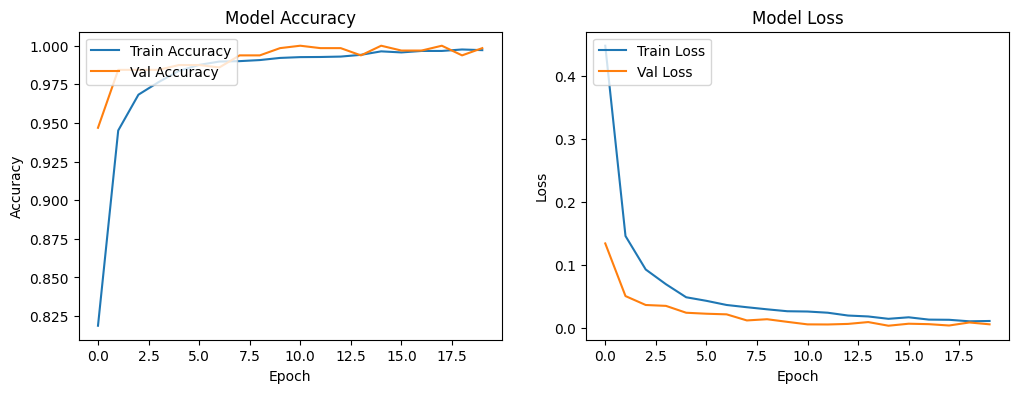

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

In [ ]:
test_labels = test_batches.classes
len(test_labels)

800

In [ ]:
preds = model.predict(x=test_batches,verbose=0)

In [ ]:
cm = confusion_matrix(y_true = test_labels, y_pred = preds.argmax(axis=1))
cm

array([[596,   4],
       [  0, 200]])

In [ ]:
loss, accuracy = model.evaluate(test_batches)
print(f'Loss: {loss}, Accuracy: {accuracy}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9971 - loss: 0.0130
Loss: 0.021263524889945984, Accuracy: 0.9950000047683716


0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520


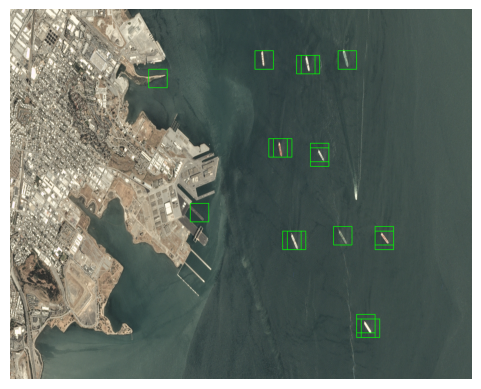

In [ ]:
def sliding_window(image, window_size, stride):
    """
    Generator function to yield sliding window patches from the image.
    Args:
    - image: Input image (numpy array).
    - window_size: Tuple (height, width) of the sliding window.
    - stride: Step size for sliding window.
    Yields:
    - x: Top-left x coordinate of the window.
    - y: Top-left y coordinate of the window.
    - window: Image patch of size window_size.
    """
    for y in range(0, image.shape[0] - window_size[0] + 1, stride):
        print(y)
        for x in range(0, image.shape[1] - window_size[1] + 1, stride):
            window = image[y:y + window_size[0], x:x + window_size[1]]
            yield x, y, window


def detect_ships(scene, model, window_size=(80, 80), stride=20, threshold=0.5):
    """
    Detect ships in a scene using a sliding window and a trained CNN model.
    Args:
    - scene: Input scene image (numpy array).
    - model: Pre-trained TensorFlow/Keras model for ship classification.
    - window_size: Tuple (height, width) of the sliding window.
    - stride: Step size for sliding window.
    - threshold: Probability threshold for classifying as a ship.
    Returns:
    - detections: List of detected bounding boxes [(x, y, width, height)].
    """
    detections = []
    for x, y, window in sliding_window(scene, window_size, stride):
        # Preprocess the window for the CNN model
        input_window = cv2.resize(window, window_size)  # Resize if necessary
        input_window = input_window / 255.0  # Normalize pixel values
        input_window = np.expand_dims(input_window, axis=0)  # Add batch dimension

        # Predict using the model
        prediction = model.predict(input_window,verbose = 0)

        # If the prediction exceeds the threshold, record the detection
        if prediction[0][1] >= threshold:
            detections.append((x, y, window_size[1], window_size[0]))  # x, y, width, height

    return detections

def visualize_detections(scene, detections):
    """
    Visualize detections by overlaying bounding boxes on the scene.
    Args:
    - scene: Input scene image (numpy array).
    - detections: List of detected bounding boxes [(x, y, width, height)].
    """
    for (x, y, w, h) in detections:
        cv2.rectangle(scene, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green boxes
    plt.imshow(cv2.cvtColor(scene, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()



# Example Usage
if __name__ == "__main__":
    # Load the scene image (example path)
    scene = cv2.imread("/content/drive/MyDrive/ShipNet/scenes/sfbay_3.png")
    scene = cv2.resize(scene,(2000,1600))
    stride = 20

    #scene = cv2.resize(scene, (2000, 1600))  # Ensure the scene matches specified dimensions

    # Run detection
    detections = detect_ships(scene, model, window_size=(80, 80), stride=stride, threshold=0.7)

    # Visualize results
    visualize_detections(scene, detections)


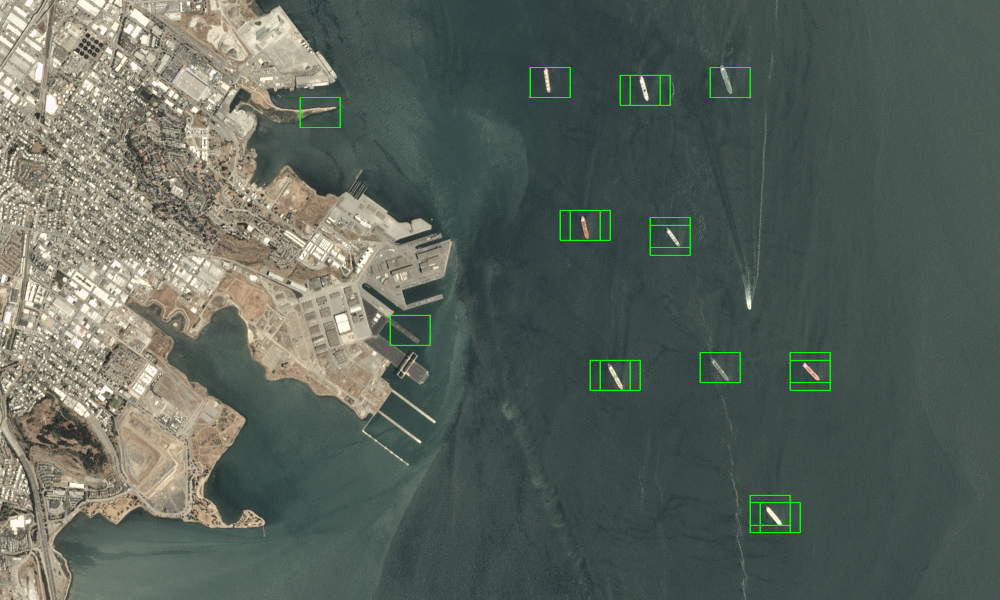

In [ ]:

scene = cv2.resize(scene,(1000,600))
from google.colab.patches import cv2_imshow
cv2_imshow(scene)


In [ ]:
model.save('/content/drive/MyDrive/ShipNet/best_model.keras')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/ShipNet/best_model.keras')